<a href="https://colab.research.google.com/github/DJ-Adams/Intermediate-ML/blob/main/Anomaly_Detection_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection
- Darlene Adams

## The Task

Your task will be to locate anomalous transactions in this data using KMeans and IsolationForest models according to the stakeholder reports that they have found that about 0.4% of transactions are fraudulent, and 99.6% are valid.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', 100)

### Load Data and Initial EDA

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/credit_card.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10000 non-null  float64
 1   V2      10000 non-null  float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

In [4]:
df.isna().sum().sum()

0

In [5]:
df.duplicated().sum()

0

### Distributions

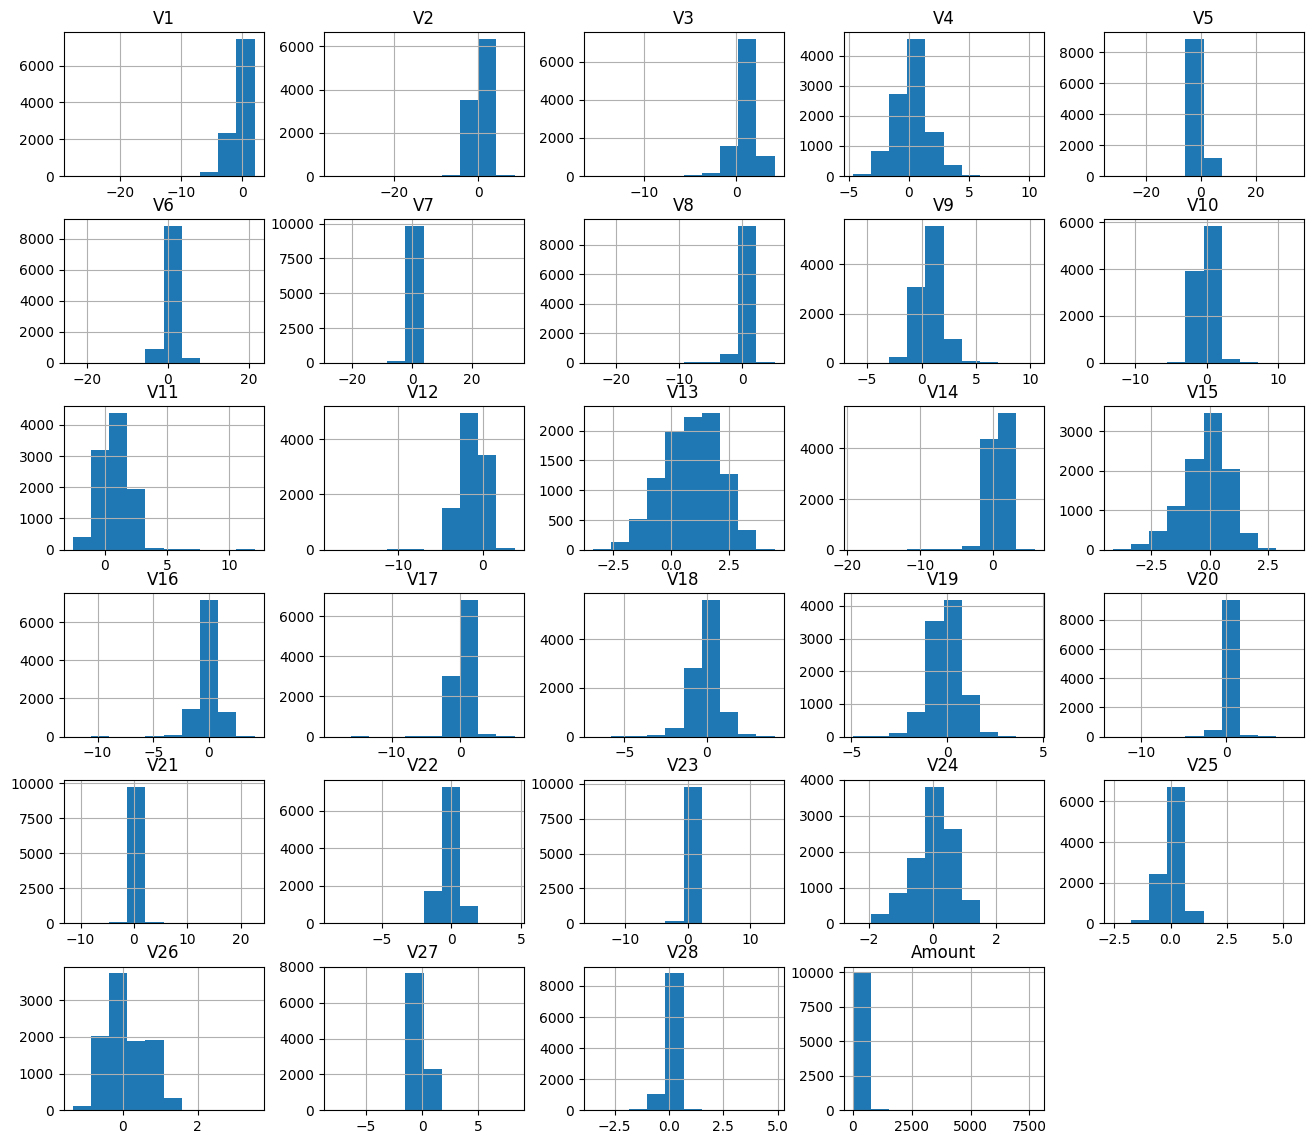

In [13]:
df.hist(figsize=(16,14));

Many of the features have short distribution ranges with substantially sized spikes

<Axes: >

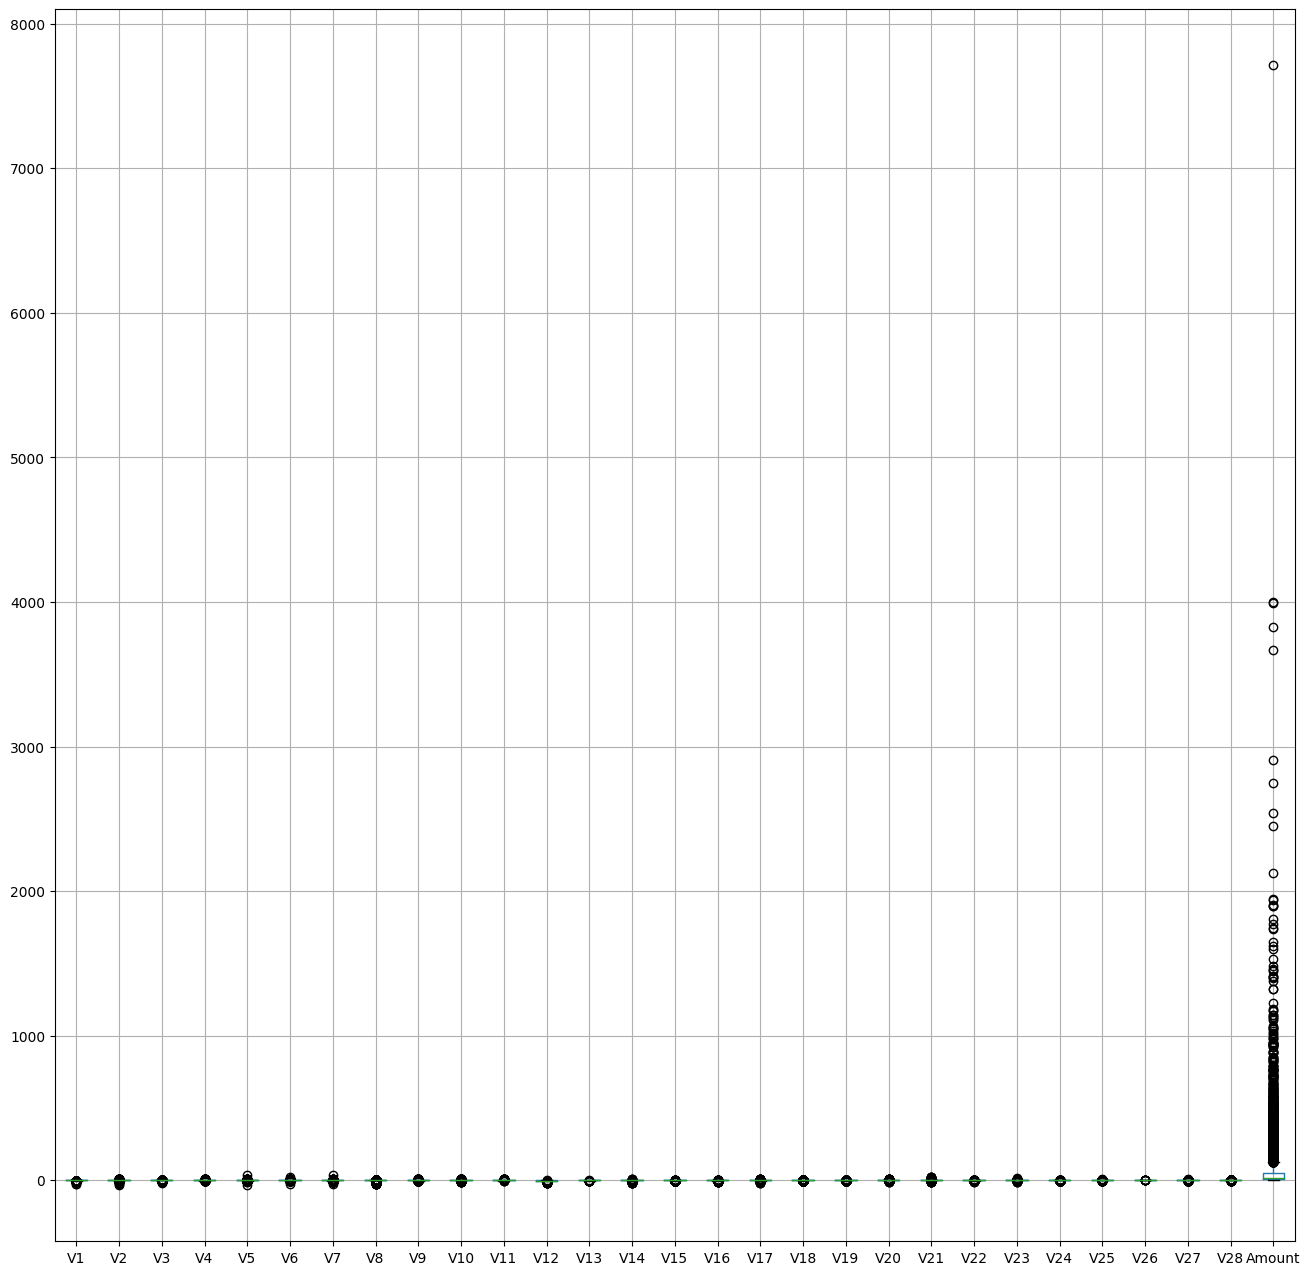

In [14]:
df.boxplot(figsize=(16,16))

<Axes: >

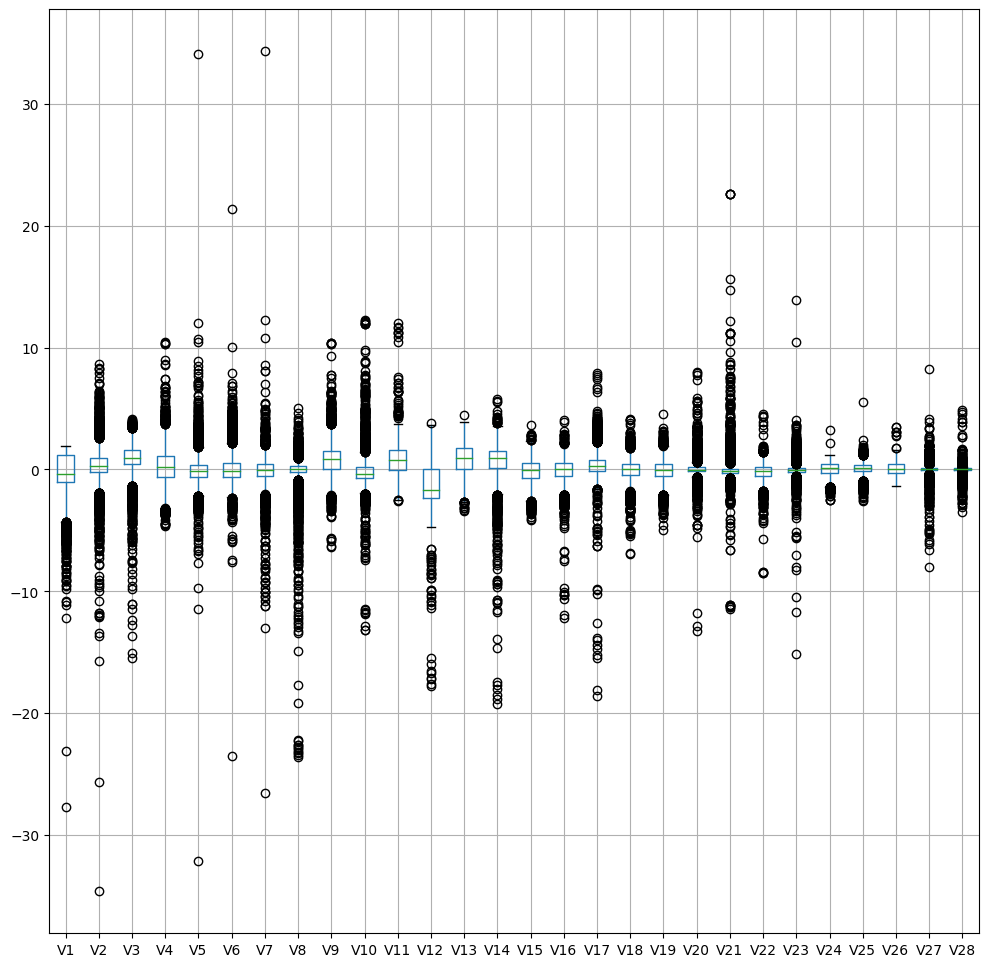

In [16]:
df1 = df.drop(columns=['Amount'])
df1.boxplot(figsize=(12,12))

This data set is so widely varied that clear cut parameters are necessary in order to determine how much of the data is actually outliers.

### KMeans

In [17]:
df_scaled = StandardScaler().fit_transform(df)
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,0.000000,4.618528e-18,4.263256e-18,-1.136868e-17,1.278977e-17,-1.563194e-17,2.842171e-18,7.105427e-19,2.273737e-17,2.273737e-17,7.958079e-17,-4.547474e-17,1.818989e-16,6.821210e-17,2.273737e-17,2.984279e-17,5.684342e-18,-3.126388e-17,1.705303e-17,8.526513e-18,-1.421085e-18,0.000000,-1.136868e-17,0.000000,1.918465e-17,2.273737e-17,2.842171e-18,-1.243450e-17,2.664535e-18
std,1.000050,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050,1.000050e+00,1.000050,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-18.006687,-2.654351e+01,-1.411218e+01,-3.466114e+00,-2.729091e+01,-1.817718e+01,-2.455962e+01,-1.877204e+01,-6.124311e+00,-1.180159e+01,-2.885705e+00,-1.081503e+01,-3.509730e+00,-1.604582e+01,-4.077583e+00,-1.383688e+01,-1.955809e+01,-8.690612e+00,-6.007225e+00,-2.235822e+01,-1.257202e+01,-13.244909,-3.085679e+01,-4.273688,-6.182844e+00,-2.599772e+00,-1.971446e+01,-1.310692e+01,-3.483590e-01
25%,-0.507861,-3.784986e-01,-4.253777e-01,-6.165018e-01,-4.985775e-01,-5.796205e-01,-4.337502e-01,-1.008889e-01,-6.342085e-01,-4.229124e-01,-7.026144e-01,-7.120035e-01,-7.091327e-01,-5.055510e-01,-5.955376e-01,-5.535057e-01,-5.130616e-01,-5.469820e-01,-6.025798e-01,-3.032860e-01,-2.353380e-01,-0.628531,-2.905271e-01,-0.586666,-5.774739e-01,-7.788192e-01,-2.242983e-01,-6.975227e-02,-3.193112e-01
50%,-0.085099,6.782439e-03,2.986867e-02,-3.808745e-02,-8.175830e-02,-2.152805e-01,1.484037e-02,6.157779e-02,3.294826e-03,-1.062683e-01,-1.815993e-02,-2.326422e-01,6.309369e-02,1.723455e-01,1.192048e-01,8.601562e-02,-2.421623e-02,4.667196e-02,-1.846964e-02,-8.676946e-02,-7.803955e-02,0.020153,-2.883205e-02,0.103214,7.637644e-02,-1.192856e-01,-2.757235e-02,5.005397e-02,-2.622415e-01
75%,0.919997,4.796908e-01,5.950950e-01,5.941939e-01,3.578826e-01,2.849753e-01,5.010253e-01,2.629713e-01,6.045470e-01,3.585611e-01,6.886560e-01,8.956822e-01,7.520007e-01,6.371526e-01,6.794896e-01,6.244954e-01,4.755387e-01,5.856934e-01,6.406927e-01,2.186046e-01,9.824494e-02,0.627215,2.339274e-01,0.659588,6.376485e-01,6.476346e-01,2.763214e-01,2.820298e-01,-6.125551e-02
max,1.454644,6.354564e+00,2.735690e+00,7.126675e+00,2.910371e+01,1.637432e+01,3.187847e+01,4.083320e+00,8.215687e+00,1.135921e+01,9.646300e+00,3.331113e+00,2.958243e+00,4.059031e+00,3.852449e+00,4.646881e+00,7.809575e+00,5.207948e+00,5.714050e+00,1.341121e+01,2.495048e+01,7.426276,2.839192e+01,5.377278,1.262788e+01,6.132634e+00,2.036787e+01,1.812750e+01,4.129275e+01


### Fit KMeans with 3 clusters

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(df_scaled)

### Determine distance from cluster centers.

In [20]:
## Find distances
from scipy.spatial.distance import cdist
distances = cdist(df_scaled, kmeans.cluster_centers_, 'euclidean')
distances

array([[2.80468161, 4.39326354, 5.85721494],
       [2.42642963, 3.68608746, 5.07508117],
       [6.5426218 , 7.33737825, 8.65600243],
       ...,
       [7.25374437, 6.4078623 , 8.24946223],
       [6.81346291, 6.26852314, 4.97246188],
       [4.88282778, 3.67991041, 5.7359755 ]])

### Find the distance to the closest cluster for each data point.

In [21]:
# Find the minimum distance to a cluster center for each data point.
min_distances = np.min(distances, axis=1)
min_distances

array([2.80468161, 2.42642963, 6.5426218 , ..., 6.4078623 , 4.97246188,
       3.67991041])

### Determine a Threshold for Anomalies at 99.6th percentile.

In [22]:
## Determine 99.7th percentile distance threshold
threshold = np.percentile(min_distances, 99.6)
threshold

20.909887868001256

### Isolate data points above the threshold

In [25]:
## Create a filter for which data points are outside the distance threshold
kmeans_filter = min_distances > threshold

## Filter the original dataset to inspect the anomalous data
anomalies = df[kmeans_filter]
anomalies

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,-0.362818,0.286155,0.487836,1.259957,0.660405,0.455263,-0.497644,0.792269,-0.978442,7.744222,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04
1376,-3.936794,-3.670519,-1.453820,2.299750,-9.749440,6.456410,10.784088,-2.160016,-0.238116,-1.004398,-0.318437,-1.981435,-0.876499,-1.095709,1.132103,1.643440,-0.853990,-0.165445,-0.810785,-2.203676,-0.979104,0.957186,2.441960,0.250607,0.300908,1.157867,1.624284,-1.638647,2452.03
1619,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43
2156,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,-1.854230,-0.644609,0.123530,0.012160,0.853694,0.960689,0.615011,-0.056334,0.515516,-1.212439,7.314347,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00
2212,-5.149638,4.261740,-1.043112,-2.872586,-0.970562,2.037714,-4.472909,-14.892657,1.713550,0.090612,1.451729,1.805170,-1.685060,1.308130,0.321223,-0.769014,1.202188,0.191807,0.202332,-3.235393,14.718212,-4.432106,2.075999,-0.025098,0.042432,-0.045874,0.619351,0.287509,4.00
2439,-12.168192,-15.732974,-0.376474,3.792613,10.658654,-7.465603,-6.907038,1.573722,0.058164,-0.421881,1.034540,2.158435,0.384870,1.586790,-0.155446,-0.394043,0.510810,-0.412623,-1.097990,4.469095,1.660209,-0.910516,0.010468,-0.097246,-0.329918,0.225916,0.201802,-2.368534,120.00
2594,-2.574940,-2.669331,-3.080133,2.043551,-11.416881,7.885721,12.219249,-1.828209,-1.475925,-1.965803,0.789085,-0.160786,1.934111,-0.228977,1.698030,1.427955,-1.219459,1.558758,1.643275,0.828357,-0.115580,0.264090,2.219739,-0.771131,0.145438,-0.240517,1.180441,-0.623651,2909.97
2654,-7.546256,3.051033,-0.524684,1.005228,0.040486,2.751676,-6.267406,-19.176657,1.049976,0.521925,-0.298362,1.618002,-1.333216,0.696135,-0.444602,-0.456586,1.504989,-0.834556,-0.606355,-3.785808,9.639417,-3.053597,2.648404,0.429294,0.300704,-0.273082,1.300662,-0.641413,29.90
2756,-10.780565,-9.940571,1.703409,3.094958,7.929119,-4.032777,-8.945496,-5.099389,2.297646,-0.234243,-0.452866,2.134734,0.251165,-0.654290,-0.396737,0.170110,0.717256,-1.794904,-0.337865,-4.829446,-4.399837,1.633000,-0.711629,0.645921,-0.549247,0.704801,3.372603,-1.307732,85.00
2911,-4.344234,4.268511,-1.580163,0.272536,-1.419244,2.603639,-11.164794,-23.632502,-1.849347,-5.217814,-0.374267,3.606761,-1.114142,3.991662,0.752753,-0.518462,2.216999,-0.100099,0.709246,5.851381,-11.273890,3.661957,-0.200435,0.920605,0.619883,-0.381170,-0.132891,0.539894,1.00


## Isolation forest

### Create and fit the model at .4

In [26]:
## As a tree-based model, the data does not need to be scaled.
## Set contamination to .004
iso = IsolationForest(contamination=.004, random_state=42)
iso.fit(df)

## Make predictions
predictions = iso.predict(df)
predictions[:5]

array([1, 1, 1, 1, 1])

### Create a Filter

In [27]:
## Create a filter
iso_filter = predictions == -1
iso_anomalies = df[iso_filter]
iso_anomalies

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,-0.362818,0.286155,0.487836,1.259957,0.660405,0.455263,-0.497644,0.792269,-0.978442,7.744222,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04
1619,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43
2156,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,-1.854230,-0.644609,0.123530,0.012160,0.853694,0.960689,0.615011,-0.056334,0.515516,-1.212439,7.314347,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00
2756,-10.780565,-9.940571,1.703409,3.094958,7.929119,-4.032777,-8.945496,-5.099389,2.297646,-0.234243,-0.452866,2.134734,0.251165,-0.654290,-0.396737,0.170110,0.717256,-1.794904,-0.337865,-4.829446,-4.399837,1.633000,-0.711629,0.645921,-0.549247,0.704801,3.372603,-1.307732,85.00
2858,-4.508547,5.050932,-2.114599,0.265771,1.263230,0.474670,-3.704011,-12.668590,0.344009,-0.674270,0.991243,0.826888,-0.233163,-3.089463,0.263483,0.806294,3.855011,0.981090,-2.197613,-2.574071,12.194849,-4.266839,0.500497,-0.100951,-0.265935,-0.472904,1.055836,0.504921,2.29
2914,-5.390190,5.141127,-2.456760,-1.433851,-2.132299,2.693505,-9.704282,-23.179640,-1.747019,-6.042641,-0.995357,3.607076,-1.278168,3.952664,-1.035516,0.438314,1.381819,-0.077463,-1.546609,5.580590,-11.102491,4.359627,1.943902,0.778397,-0.705948,-1.005957,-0.016154,0.522824,1.00
2917,-5.948482,5.573239,-2.932061,-1.450307,-2.521964,2.641657,-10.045540,-22.746370,-1.726559,-5.962109,-1.119455,3.774837,-1.215732,4.197010,-1.059259,0.541702,1.540329,-0.055749,-1.581913,5.593471,-11.092565,4.327552,2.009214,0.774036,-0.630253,-0.998636,-0.031049,0.518083,7.50
2923,-6.200114,5.025406,-2.742492,-0.940903,-6.656259,5.432294,-9.198175,-22.588547,-3.244295,-5.453339,-1.582292,2.771415,-0.794303,3.189651,-2.359859,2.825793,2.126128,-1.303542,-1.429571,4.592909,-11.235266,4.393846,1.943002,0.846005,-1.343379,-0.707634,-0.210219,0.066529,544.62
5303,-8.733429,-5.681953,2.253879,3.930311,-0.916149,4.355297,5.400286,-4.994383,6.819787,6.764860,3.553336,-3.717391,0.665064,-4.496585,-0.533313,-1.143550,-0.777258,-0.988692,0.868138,-5.571503,-2.626882,1.525158,-1.428302,-0.030181,-0.029485,-0.264455,-7.976100,4.712560,553.60
5412,-8.053149,7.045990,-1.102994,-0.870690,-1.360528,4.754590,-7.669995,-23.464595,3.056101,2.085637,2.225717,-0.278070,0.345162,2.448522,-0.759153,0.149231,2.197302,0.425360,-0.767092,-4.578147,22.565680,-8.420246,3.511462,-0.526480,0.276928,0.207147,1.180975,0.194628,5.49


## Compare KMeans and Isolation Forest

In [29]:
## What percent of the data do the models agree are anomalous?

## Find where models agree on an anomaly
agree_filter = iso_filter & kmeans_filter
agree_anomaly = df_scaled[agree_filter]

## Count how many they agree on
percent_agree = 100 * len(agree_anomaly) / len(df)
print(f'Of {len(iso_anomalies)} samples that each model identified as anomalous, they agree on {len(agree_anomaly)}.  This is {percent_agree}% of the total data')

Of 40 samples that each model identified as anomalous, they agree on 27.  This is 0.27% of the total data


In [30]:
## Inspect the samples that the models agree on
df[agree_filter]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,-0.362818,0.286155,0.487836,1.259957,0.660405,0.455263,-0.497644,0.792269,-0.978442,7.744222,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04
1619,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43
2156,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,-1.854230,-0.644609,0.123530,0.012160,0.853694,0.960689,0.615011,-0.056334,0.515516,-1.212439,7.314347,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00
2756,-10.780565,-9.940571,1.703409,3.094958,7.929119,-4.032777,-8.945496,-5.099389,2.297646,-0.234243,-0.452866,2.134734,0.251165,-0.654290,-0.396737,0.170110,0.717256,-1.794904,-0.337865,-4.829446,-4.399837,1.633000,-0.711629,0.645921,-0.549247,0.704801,3.372603,-1.307732,85.00
2914,-5.390190,5.141127,-2.456760,-1.433851,-2.132299,2.693505,-9.704282,-23.179640,-1.747019,-6.042641,-0.995357,3.607076,-1.278168,3.952664,-1.035516,0.438314,1.381819,-0.077463,-1.546609,5.580590,-11.102491,4.359627,1.943902,0.778397,-0.705948,-1.005957,-0.016154,0.522824,1.00
2917,-5.948482,5.573239,-2.932061,-1.450307,-2.521964,2.641657,-10.045540,-22.746370,-1.726559,-5.962109,-1.119455,3.774837,-1.215732,4.197010,-1.059259,0.541702,1.540329,-0.055749,-1.581913,5.593471,-11.092565,4.327552,2.009214,0.774036,-0.630253,-0.998636,-0.031049,0.518083,7.50
2923,-6.200114,5.025406,-2.742492,-0.940903,-6.656259,5.432294,-9.198175,-22.588547,-3.244295,-5.453339,-1.582292,2.771415,-0.794303,3.189651,-2.359859,2.825793,2.126128,-1.303542,-1.429571,4.592909,-11.235266,4.393846,1.943002,0.846005,-1.343379,-0.707634,-0.210219,0.066529,544.62
5303,-8.733429,-5.681953,2.253879,3.930311,-0.916149,4.355297,5.400286,-4.994383,6.819787,6.764860,3.553336,-3.717391,0.665064,-4.496585,-0.533313,-1.143550,-0.777258,-0.988692,0.868138,-5.571503,-2.626882,1.525158,-1.428302,-0.030181,-0.029485,-0.264455,-7.976100,4.712560,553.60
5412,-8.053149,7.045990,-1.102994,-0.870690,-1.360528,4.754590,-7.669995,-23.464595,3.056101,2.085637,2.225717,-0.278070,0.345162,2.448522,-0.759153,0.149231,2.197302,0.425360,-0.767092,-4.578147,22.565680,-8.420246,3.511462,-0.526480,0.276928,0.207147,1.180975,0.194628,5.49
5413,-8.617888,7.467017,-1.565033,-0.884684,-1.699891,4.669832,-8.058865,-23.022348,3.079393,2.172834,2.099885,-0.106140,0.406652,2.695299,-0.784020,0.248161,2.357937,0.447471,-0.802447,-4.552711,22.580675,-8.454599,3.575743,-0.531607,0.351640,0.213673,1.157192,0.193203,1.98


Questions:

- a. How many anomalies did the two approaches agree on?
  - They agreed on 27 of the 40 anomalies that they identified.
- b. What percentage of the anomalies did the two approaches agree on?
  - The 27 anomalies that they agreed upon represent 0.27% of the total data.